In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pandas as pd
from src.utils import get_generations, get_metrics, get_all, _process_evalharness_results, get_superglue_results, get_empirical_cdf, print_random_examples, plot_superglue_task, get_auc, _get_params_llama, get_good_models, get_watermark_overrides

/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper Functions

In [2]:

def _get_rank(param_info):
    """
    Given a key, returns the rank of the model that was dropped
    """
    return int(param_info.split('_r')[-1])
    

def _get_layer(param_info):
    """
    Given a key, returns the layer of the model that was dropped
    """
    return int(param_info.split('_')[0])


def _get_mlp_type(param_info):

    layer = _get_layer(param_info)
    if layer == -1:
        return 'mlp_weight'
    else:
        mlp_type = '_'.join(param_info.split('_')[2:4])
        return mlp_type


def check_match(key, param_data):
    """
    Given a key, check if it matches the desired data to display
    """
    param_info = key[0]
    matches = True
    if 'rank' in param_data.keys():
        if _get_rank(param_info) != param_data['rank']:
            matches = False
    layer = _get_layer(param_info)
    if 'layer' in param_data.keys():
        if param_data['layer'] != layer:
            matches = False
    if 'mlp_type' in param_data.keys() and layer != -1:
        mlp_type = '_'.join(param_info.split('_')[2:4])
        if param_data['mlp_type'] != mlp_type:
            matches = False


    return matches
    
def get_title(param_data):
    """
    Given the parameters, return the title for the plot
    """
    title = ''
    if 'layer' in param_data.keys():
        title += str(param_data['layer'])
    if 'mlp_type' in param_data.keys():
        title += '_' + param_data['mlp_type']
    if 'rank' in param_data.keys():
        title += '_r' + str(param_data['rank'])
    
    if 'gate_up_proj' in title:
        title = title.replace('gate_up_proj', 'mlp_gate_up_proj')
    
    return title

In [3]:
def get_params(dir):
    model_path = os.path.join(dir, 'models')
    param_path = os.path.join(model_path, os.listdir(model_path)[-1], 'params.json')
    with open(param_path) as f:
        config = json.load(f)


    model_name = config['tokenizer_name']
    param_names = config['watermark_param_names'][0]
    variance = config['variance']
    if 'rank_to_drop' in config.keys():
        rank_to_drop = config['rank_to_drop']
    else:
        rank_to_drop = 0

    if '_ran_' in dir:

        found = re.search(r'_ran_(\d+)', dir)
        if found:
            rank_to_drop = int(found.group(1))


    key = (param_names, variance, rank_to_drop)
    
    return key, model_name

def get_generations(parent):
    """
    Given a path to the parent directory of saved amulet generations, returns a dictionary of generations, where the key is the model parameters and the value is the generations list
    """
    generations = {}

    for dirname in os.listdir(parent):
        dir = os.path.join(parent, dirname)
        try:
            key, model_name = get_params(dir)
            if model_name not in generations.keys():
                generations[model_name] = {}
            with open(os.path.join(dir, 'generations.json')) as f:
                generations[model_name][key] = json.load(f)

        except Exception as e:
            print(e)
            print(f"Error processing {dir}")
        # gen_path = os.path.join(parent, dirname, 'generations.json')
        # if os.path.exists(gen_path):
        #     with open(gen_path) as f:
        #         generations[key] = json.load(f)
        # else:
        #     print(f"No generations found for {key}")

    return generations


def get_metrics(parent,  key_is_path=False):
    """
    Returns eval harness metrics for all experiments in a directory
    """
    metrics = {}
    for dirname in os.listdir(parent):
        try:
            dir = os.path.join(parent, dirname)
            key, model_name = get_params(dir)
            metrics_path = os.path.join(parent, dirname, 'data/eval_results/results.json')
            with open(metrics_path) as f:
                results = json.load(f)
            
            if model_name not in metrics.keys():
                metrics[model_name] = {}
            
            metrics[model_name][key] = _process_evalharness_results(results)
            if key_is_path:
                metrics[model_name][key]['path'] = dir
        except Exception as e:

            print(f"Error processing {dir}: {e}")
    return metrics



def get_layer_mlp_type(param_name):
    splits = param_name.split('.')
    return splits[2], splits[4]

def is_match(param_info, param):
    
    keys = set(param_info.keys())
    param_names, variance, rank_to_drop = param
    layer, mlp_type = get_layer_mlp_type(param_names)

    param_data ={
        'layer': int(layer),
        'mlp_type': mlp_type,
        'rank': rank_to_drop,
        'variance': variance
    }
    matches = True
    for key in keys:
        if param_info[key] != param_data[key]:
            matches = False
            break
    return matches



def plot_superglue_task(results, task, param, include_gsm8k=False):
    """
    Plots the superglue task results
    """
    SUPERGLUE_TASKS = [
        'boolq',
        'cb',
        'copa',
        'multirc',
        'record',
        'rte',
        'wic',
        'wsc',
    ]
    if include_gsm8k:
        SUPERGLUE_TASKS += ['gsm8k', 'gsm8k_cot_self_consistency'] # GSM8K is not a superglue task but included for math reasoning

    assert task in SUPERGLUE_TASKS, f"Task {task} not in superglue tasks"

    if task == 'record':
        metric = 'em'
    elif task in {'gsm8k', 'gsm8k_cot_self_consistency'}:
        metric = 'exact_match,flexible-extract'
    else:
        metric = 'acc'

    vars = []
    scores = []
    errors = []

    llama_score = 0.0
    llama_stderr = 0.0

    ## Sort by key
    results = {key: results[key] for key in sorted(results.keys())}

    for key, val in results.items():
        if key[1] == 0 and key[2] == 0:
            label = 'No Watermark'
        else:
            label = f'Var {key[1]}, r {key[2]}'
        vars.append(label)

        score = val[task][metric]
        error = val[task][metric + '_stderr']

        if key[1] == 0 and key[2] == 0:
            llama_score = score
            llama_stderr = error


        scores.append(score)
        errors.append(error)


    fig, ax = plt.subplots()

    ax.bar(vars, scores, yerr=errors, capsize=5, width=0.5, alpha=0.5)
    if metric == 'acc':
        ylabel = 'Accuracy'
    elif metric == 'em':
        ylabel = 'Exact Match'
    else:
        ylabel = metric


    ax.axhline(llama_score, color='red', label='Llama', linestyle='--', linewidth=1)
    ax.axhline(llama_score + llama_stderr, color='red', linestyle='--', linewidth=1, alpha=0.1)
    ax.axhline(llama_score - llama_stderr, color='red', linestyle='--', linewidth=1, alpha=0.1)
    # ax.fill_between([*ax.get_xlim()], llama_score - llama_stderr, llama_score + llama_stderr, color='red', alpha=0.1)
        
    ax.set_ylabel(ylabel)
    ax.set_title(f'SuperGLUE {task} ({param})')
    fig.autofmt_xdate()
    return fig, ax

# Getting Data

In [4]:
# parent = './amlt/09-18-watermark-r0'
# parent = './amlt/09-18-watermark-r64'
# parent = './amlt/09-18-watermark-phi-r0'
# parent = './amlt/09-18-laser-watermark-mistral'
# parent = './amlt/09-18-laser-watermark-phi'
# parent = './amlt/09-19-laser-watermark-llama'
# parent = './amlt/09-19-watermark-llama'
# parent = './amlt/09-22-watermark-phi'
# parent = './amlt/09-22-watermark-llama'
# parent = './amlt/09-22-watermark-mistral'
parent = './amlt/09-23-watermark-mistral'
# parent = './amlt/09-25-watermark-phi'



generations = get_generations(parent)
metrics = get_metrics(parent)

In [11]:
generations['microsoft/Phi-3-mini-4k-instruct'][('model.layers.30.mlp.gate_up_proj.weight', 0.0003, 64)][0].keys()

dict_keys(['prompt', 'prompt_token_ids', 'response', 'response_token_ids', 'logprobs'])

In [6]:
# model = 'mistralai/Mistral-7B-v0.3'
model = 'microsoft/Phi-3-mini-4k-instruct'
# model = 'meta-llama/Meta-Llama-3.1-8B'
param_info = {
    'layer': 31,
    # 'layer': 28,
    # 'mlp_type': 'up_proj',
    'mlp_type': 'down_proj',
    # 'mlp_type': 'gate_proj',
    # 'mlp_type': 'gate_up_proj',
    # 'rank': 64,
}

min_prob = 1e-18
generations_param = {key: value for key, value in generations[model].items() if is_match(param_info, key)}
data_param = {key: get_all(value, min_prob) for key, value in generations_param.items()}
metrics_param = {key: value for key,value in metrics[model].items() if is_match(param_info, key)}

# unwatermarked_parent = './amlt/09-04-eval-models'
unwatermarked_parent = './amlt/09-18-eval-models/'
if 'mistral' in model:
    base_model = 'Mistral'
    # unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_mistralai_Mistral-7B-v0.3')
    unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-18-eval-models_mod_mistralai_Mistral-7B-v0.3')

elif 'Phi' in model or 'phi' in model:
    base_model = 'Phi-3'
    # unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_microsoft_Phi-3-mini-4k-instruct')
    # unwatermarked_path = './amlt/09-13-eval-phi.yaml/grid_09-13-eval-phi.yaml_mod_microsoft_Phi-3-mini-4k-instruct'
    unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-18-eval-models_mod_microsoft_Phi-3-mini-4k-instruct')
# elif 'Llama-3' in parent:
elif 'llama' in model and '3' in model: # Llama-3
    base_model = 'Llama-3'
    # unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_meta-llama_Meta-Llama-3.1-8B')
    unwatermarked_path = 'amlt/09-19-eval-llama/grid_09-19-eval-llama_mod_meta-llama_Meta-Llama-3.1-8B'
    
# else: # Llama-2
#     model = 'Llama-2'
#     unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_meta-llama_Llama-2-7b-hf')

with open(os.path.join(unwatermarked_path, 'data/eval_results/results.json')) as f:
    unwatermarked_metrics = json.load(f)

unwatermarked_metrics = _process_evalharness_results(unwatermarked_metrics)
metrics_param.update({('',0,0): unwatermarked_metrics})

KeyError: 'pvalue'

# Summary statistics

In [6]:
sig_pval = 0.05


include_gsm8k = False

num_passed = {}
log_probs_diff = {}
superglue_score = {}
superglue_stderr = {}
gsm8k_scores = {}
gsm8k_stderrs = {}


for key, data in data_param.items():

    num_passed[key] = data[data['pvalue'] < sig_pval].shape[0] / data.shape[0]
    log_probs_diff[key] = data['logprob_diff_per_token'].mean()
    
    superglue_score[key] = get_superglue_results(metrics_param[key])[1]
    superglue_stderr[key] = get_superglue_results(metrics_param[key])[2]

    gsm8k_score, gsm8k_stderr = get_superglue_results(metrics_param[key])[-1]
    gsm8k_scores[key] = gsm8k_score
    gsm8k_stderrs[key] = gsm8k_stderr
    
    
print(f"Model: {model}")
# param_data = {key:param_data[key] for key in sorted(param_data.keys())}
param_info = {key:param_info[key] for key in sorted(param_info.keys())}
for key, val in param_info.items():
    print(f"{key}: {val}")
print('#' * 40 + '\n')


print(f"Significance threshold: {sig_pval:.4f}")
for key in num_passed.keys():
    print(f"Fraction significant generations (var {key[1]}, rank {key[2]}, {key[0]}): {num_passed[key]:.4f}")
print('\n')

# llama_score = np.mean(get_superglue_results(llama_metrics)[1])
# llama_stderr = np.mean(get_superglue_results(llama_metrics)[2])
unwatermarked_score = np.mean(get_superglue_results(unwatermarked_metrics)[1])
unwatermarked_stderr = np.mean(get_superglue_results(unwatermarked_metrics)[2])
print(f"Superglue scores")
# print(f"Llama score: {llama_score:.4f} +/- {llama_stderr:.4f}")
print(f"Unwatermarked score: {unwatermarked_score:.4f} +/- {unwatermarked_stderr:.4f}")
for key in superglue_score.keys():
    if key[1] > 0:
        print(f"SuperGlue score (var {key[1]}, rank {key[2]}, {key[0]}): {np.mean(superglue_score[key]):.4f} +/- {np.mean(superglue_stderr[key]):.4f}")



unwatermarked_gsm8k_score, unwatermarked_gsm8k_stderr = get_superglue_results(unwatermarked_metrics)[-1]

try:
    print(f"\nGSM8k scores")
    print(f"Unwatermarked score: {unwatermarked_gsm8k_score:.4f} +/- {unwatermarked_gsm8k_stderr:.4f}")
    for key in gsm8k_scores.keys():
        if key[1] > 0:
            print(f"GSM8k score (var {key[1]}, rank {key[2]}, {key[0]}): {np.mean(gsm8k_scores[key]):.4f} +/- {np.mean(gsm8k_stderrs[key]):.4f}")

except:
    print("No GSM8k scores available")


print('\n')
for key in log_probs_diff.keys():
    print(f"Mean token logprob difference (var {key[1]}, rank {key[2]}, {key[0]}): {log_probs_diff[key]:.4f}")


Model: mistralai/Mistral-7B-v0.3
layer: 31
mlp_type: down_proj
########################################

Significance threshold: 0.0500
Fraction significant generations (var 1e-05, rank 0, model.layers.31.mlp.down_proj.weight): 0.9960
Fraction significant generations (var 3e-06, rank 128, model.layers.31.mlp.down_proj.weight): 0.9260
Fraction significant generations (var 3e-06, rank 0, model.layers.31.mlp.down_proj.weight): 0.9260
Fraction significant generations (var 3e-06, rank 64, model.layers.31.mlp.down_proj.weight): 0.9260
Fraction significant generations (var 1e-05, rank 128, model.layers.31.mlp.down_proj.weight): 0.9960
Fraction significant generations (var 1e-05, rank 64, model.layers.31.mlp.down_proj.weight): 0.9960


Superglue scores
Unwatermarked score: 0.6836 +/- 0.0260
SuperGlue score (var 1e-05, rank 0, model.layers.31.mlp.down_proj.weight): 0.6493 +/- 0.0261
SuperGlue score (var 3e-06, rank 128, model.layers.31.mlp.down_proj.weight): 0.6604 +/- 0.0261
SuperGlue score (v

# Plotting

AUC (var 3e-06, rank model.layers.31.mlp.down_proj.weight, 0): 0.9845
AUC (var 3e-06, rank model.layers.31.mlp.down_proj.weight, 64): 0.9845
AUC (var 3e-06, rank model.layers.31.mlp.down_proj.weight, 128): 0.9845
AUC (var 1e-05, rank model.layers.31.mlp.down_proj.weight, 0): 0.9981
AUC (var 1e-05, rank model.layers.31.mlp.down_proj.weight, 64): 0.9981
AUC (var 1e-05, rank model.layers.31.mlp.down_proj.weight, 128): 0.9981


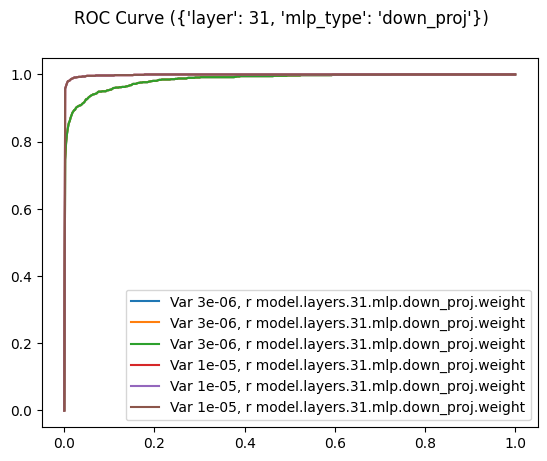

In [7]:
grid_size = 500
fig, ax = plt.subplots()
data_param = {key: data_param[key] for key in sorted(data_param.keys())}
for key, data in data_param.items():
    grid, cdf = get_empirical_cdf(data['pvalue'], grid_size=grid_size)
    auc = get_auc(grid, cdf)
    print(f"AUC (var {key[1]}, rank {key[0]}, {key[2]}): {auc:.4f}")
    ax.plot(grid, cdf, label=f'Var {key[1]}, r {key[0]}')

ax.legend()
fig.suptitle(f'ROC Curve ({param_info})')
plt.show()

# Superglue Metrics

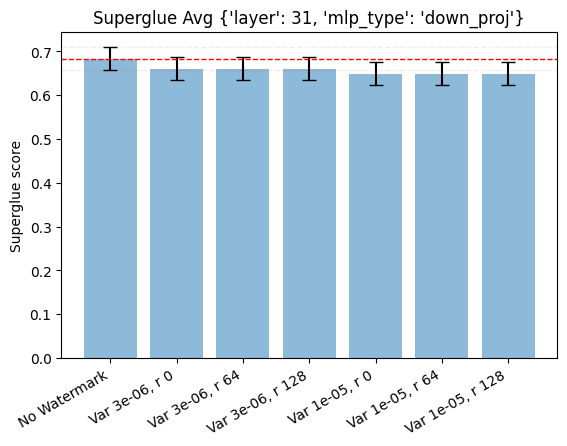

In [8]:
fig, ax  = plt.subplots()

vars, scores, errors = [], [], []


superglue_score = {key: superglue_score[key] for key in sorted(superglue_score.keys())}
vars.append('No Watermark')
scores.append(unwatermarked_score)
errors.append(unwatermarked_stderr)
for key in superglue_score.keys():
    scores.append(np.mean(superglue_score[key]))
    errors.append(np.mean(superglue_stderr[key]))
    vars.append(f'Var {key[1]}, r {key[2]}')

ax.bar(vars, scores, yerr=errors, alpha=0.5, capsize=5)
ax.axhline(unwatermarked_score, label='Unwatermarked', linestyle='--', linewidth=1, color='red')
ax.axhline(unwatermarked_score - unwatermarked_stderr, linestyle='--', linewidth=1, color='red', alpha=0.1)
ax.axhline(unwatermarked_score + unwatermarked_stderr, linestyle='--', linewidth=1, color='red', alpha=0.1)


ax.set_ylabel('Superglue score')
ax.set_title(f'Superglue Avg {param_info}')

fig.autofmt_xdate()
plt.show()

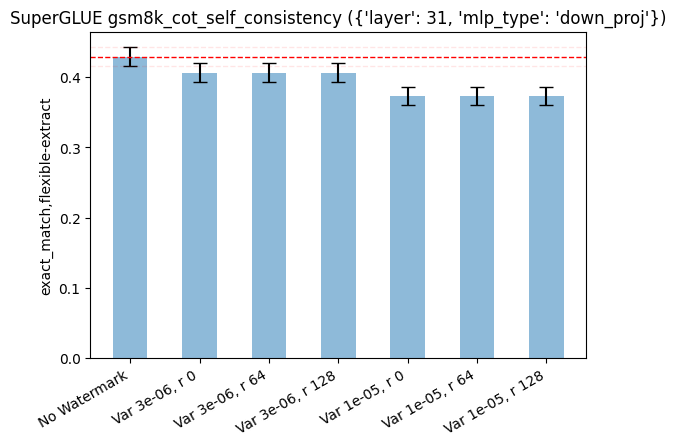

In [9]:
try:
    fig, ax = plot_superglue_task(metrics_param, 'gsm8k', param_info, include_gsm8k=True)
    plt.show()
except:
    try:
        fig, ax = plot_superglue_task(metrics_param, 'gsm8k_cot_self_consistency', param_info, include_gsm8k=True)
        plt.show()
    except:
        print(f"No GSM8k scores available for {param_info}")

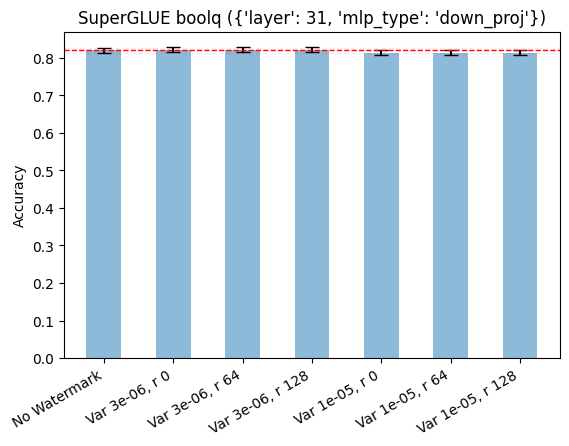

In [10]:
fig, ax = plot_superglue_task(metrics_param, 'boolq', param_info)
plt.show()

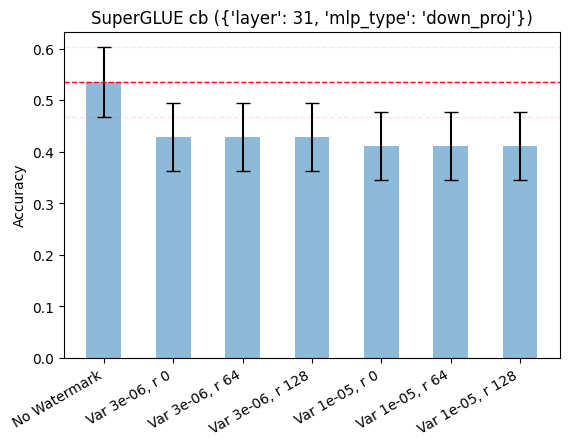

In [11]:
fig, ax = plot_superglue_task(metrics_param, 'cb', param_info)
plt.show()

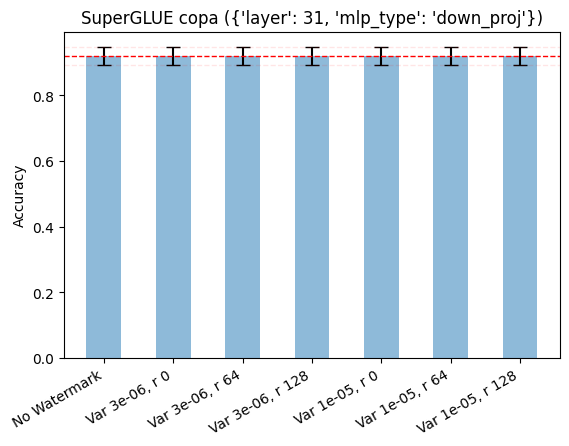

In [12]:
fig, ax = plot_superglue_task(metrics_param, 'copa', param_info)
plt.show()

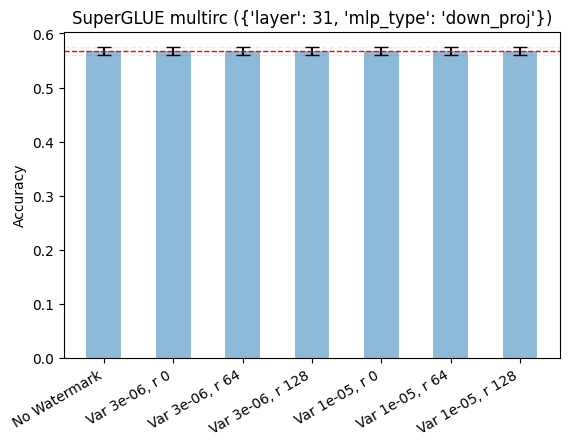

In [13]:
fig, ax = plot_superglue_task(metrics_param, 'multirc', param_info)
plt.show()

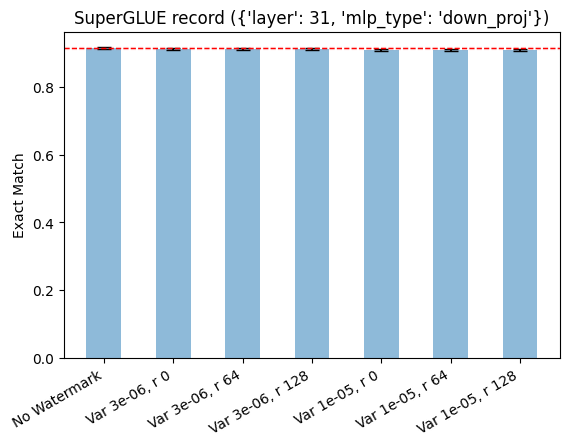

In [14]:
fig, ax = plot_superglue_task(metrics_param, 'record', param_info)
plt.show()

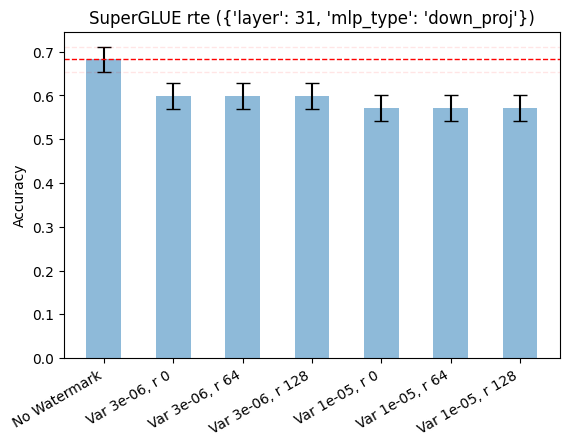

In [15]:
fig, ax = plot_superglue_task(metrics_param, 'rte', param_info)
plt.show()

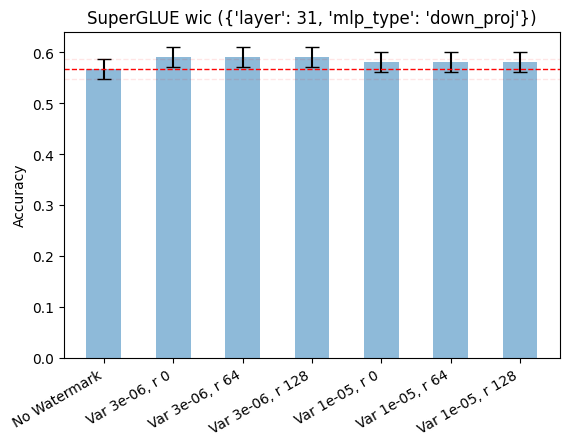

In [16]:
fig, ax = plot_superglue_task(metrics_param, 'wic', param_info)
plt.show()

# Extra Plots

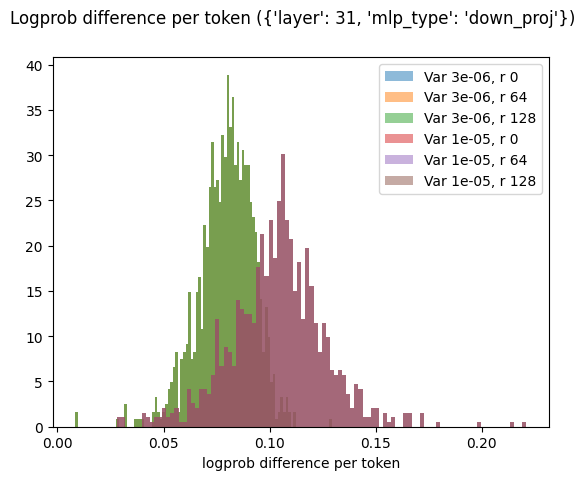

In [17]:
fig, ax = plt.subplots()
bins = 100
alpha = 0.5

for key, data in data_param.items():
    ax.hist(data['logprob_diff_per_token'], density=True, label=f'Var {key[1]}, r {key[2]}', alpha=alpha, bins=bins)
ax.set_xlabel('logprob difference per token')
ax.legend()
fig.suptitle(f"Logprob difference per token ({param_info})")
plt.show()

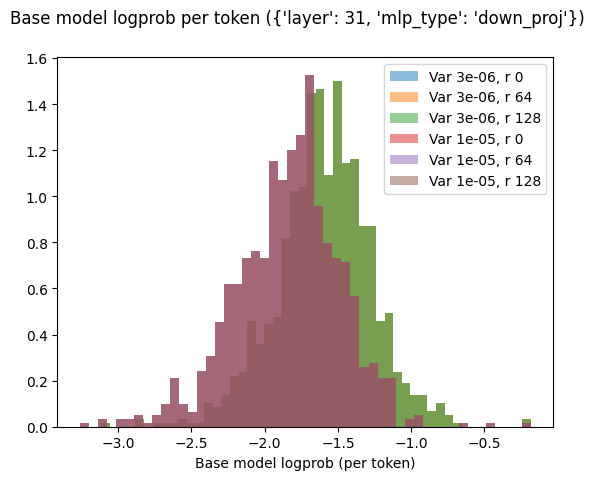

In [18]:
fig, ax = plt.subplots()
bins= 50
alpha = 0.5

for key, data in data_param.items():
    ax.hist(data['base_model_logprob'] / data['length'], density=True, label=f'Var {key[1]}, r {key[2]}', alpha=alpha, bins=bins)


ax.set_xlabel('Base model logprob (per token)')
ax.legend()

fig.suptitle(f"Base model logprob per token ({param_info})")

plt.show()

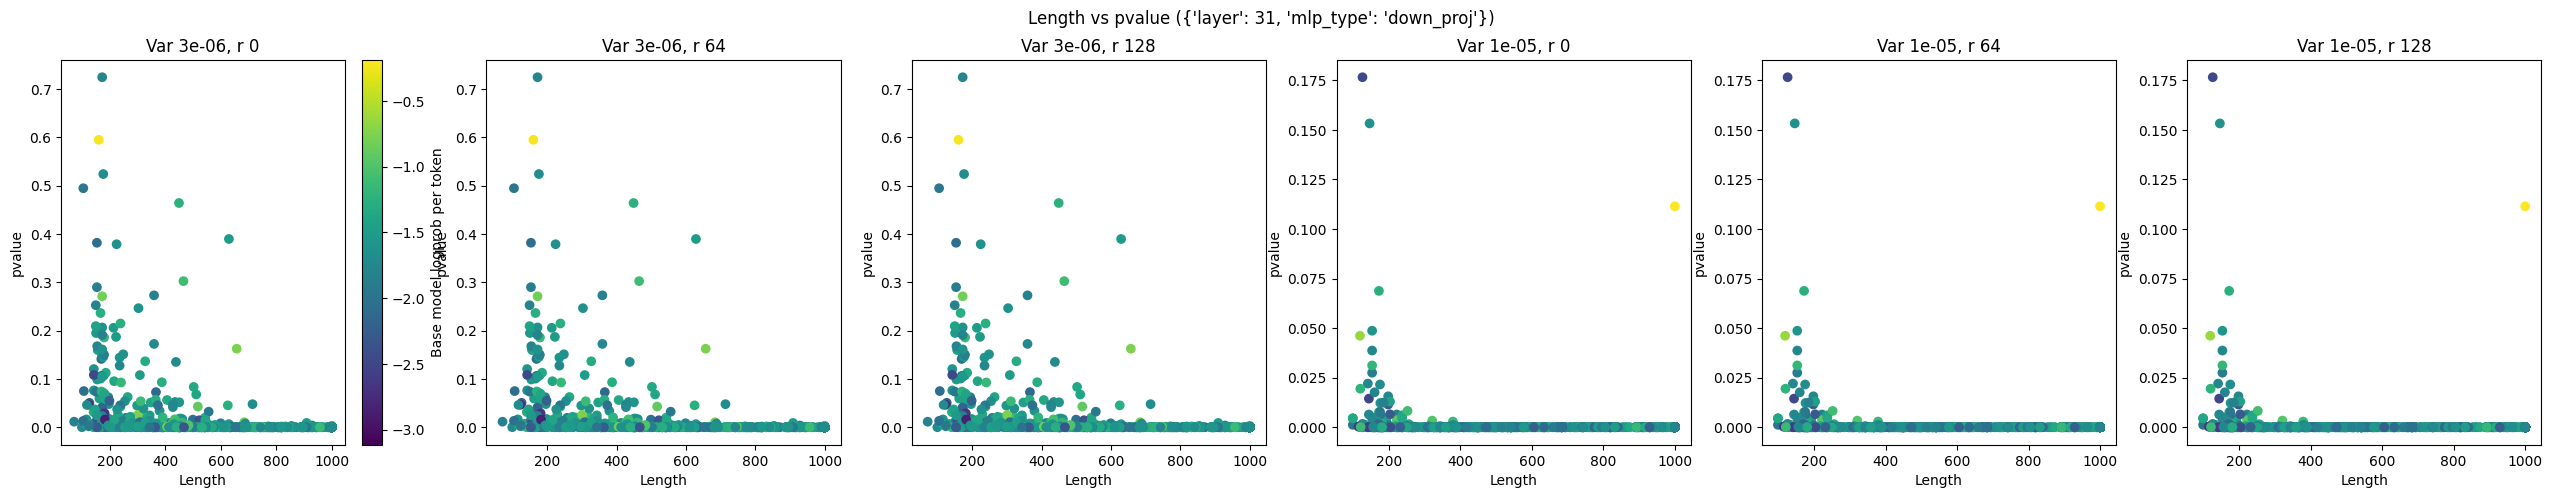

In [19]:
fig, ax = plt.subplots(1,len(data_param), figsize=(2 + 5*len(data_param),5))
scatters = []
for i, (key, data) in enumerate(data_param.items()):
    scatter_i = ax[i].scatter(data['length'], data['pvalue'], c=data['base_model_logprob'] / data['length'], cmap='viridis')
    ax[i].set_xlabel('Length')
    ax[i].set_ylabel('pvalue')
    ax[i].set_title(f'Var {key[1]}, r {key[2]}')
    scatters.append(scatter_i)

cbar = plt.colorbar(scatters[0], ax=ax[0])
cbar.set_label('Base model logprob per token')


fig.suptitle(f"Length vs pvalue ({param_info})")

plt.show()

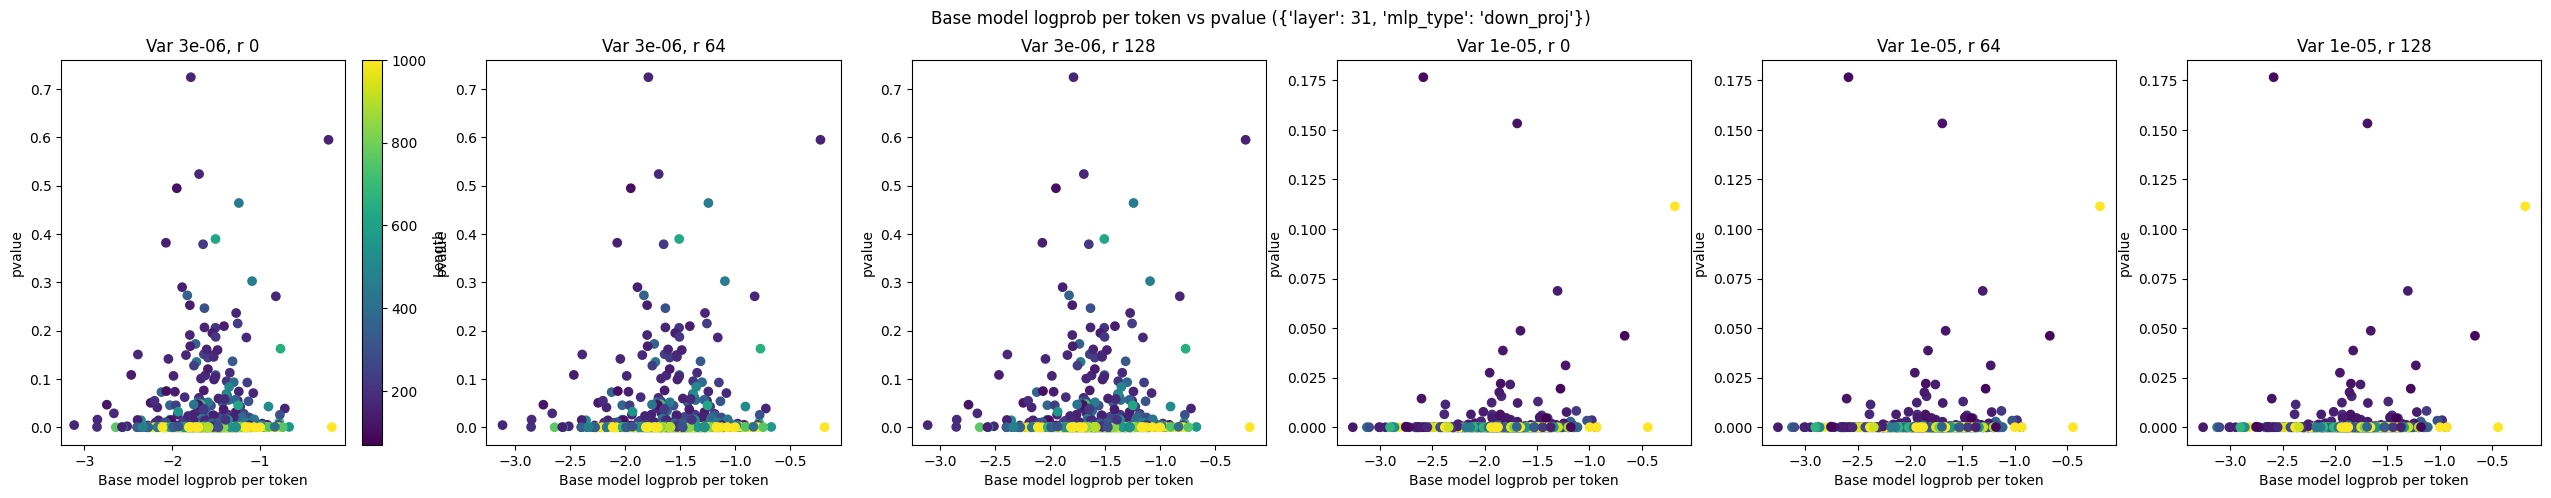

In [20]:
fig, ax = plt.subplots(1,len(data_param), figsize=(2 + 5*len(data_param),5))
scatters = []
for i, (key, data) in enumerate(data_param.items()):
    scatter_i = ax[i].scatter(data['base_model_logprob'] / data['length'], data['pvalue'], c=data['length'], cmap='viridis')
    ax[i].set_xlabel('Base model logprob per token')
    ax[i].set_ylabel('pvalue')
    ax[i].set_title(f'Var {key[1]}, r {key[2]}')
    scatters.append(scatter_i)

cbar = plt.colorbar(scatters[0], ax=ax[0])
cbar.set_label('Length')
fig.suptitle(f"Base model logprob per token vs pvalue ({param_info})")

plt.show()

In [21]:
## Write a function given parent directory that returns all paths with basenames `wins.json`
def get_wins(parent):
    wins_paths = []

    for root, dirs, files in os.walk(parent):
        for file in files:
            if file == 'wins.json':
                wins_paths.append(os.path.join(root, *dirs, file))

    wins = {}
    for win_path in wins_paths:
        with open(win_path, 'r') as f:
            win = json.load(f)
        
        overrides = win['param']
        watermarked_wins = win['watermarked_wins']
        total = win['total']
        frac_winning = watermarked_wins / total
        wins[overrides] = frac_winning
        # print(f"{overrides} won {frac_winning:.4f} of the time")
    return wins


In [22]:
win_parent = './data'
wins = get_wins(win_parent)
wins = dict(sorted(wins.items(), key=lambda x: x[1], reverse=True))
for override, win_rate in wins.items():
    print(f"{override}: {win_rate:.4f}")

llama_meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@gate_proj@@@weight@___@3e-5: 0.5248
llama_meta-llama/Meta-Llama-3.1-8B@___@64@___@28@@@up_proj@@@weight@___@3e-5: 0.5245
llama_meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@down_proj@@@weight@___@1e-4: 0.5211
llama_meta-llama/Meta-Llama-3.1-8B@___@64@___@28@@@gate_proj@@@weight@___@3e-5: 0.5033
llama_meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@up_proj@@@weight@___@3e-5: 0.5026
llama_meta-llama/Meta-Llama-3.1-8B@___@64@___@28@@@down_proj@@@weight@___@3e-5: 0.5006
llama_meta-llama/Meta-Llama-3.1-8B@___@64@___@28@@@up_proj@@@weight@___@1e-4: 0.4917
Llama-2-7b-hf@___@0@___@-1@___@none@___@weight@___@3e-06: 0.4824
llama_meta-llama/Meta-Llama-3.1-8B@___@64@___@28@@@down_proj@@@weight@___@1e-4: 0.4816
llama_meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@down_proj@@@weight@___@3e-5: 0.4784
llama_meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@up_proj@@@weight@___@1e-4: 0.4778
llama_meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@gate_proj@@@weight@___

# Getting good models

In [23]:

def get_watermark_overrides(good_models_key):

    model, key = good_models_key
    param_name, var, rank = key
    layer, mlp_type = get_layer_mlp_type(param_name)

    param_name = f'{layer}@@@{mlp_type}@@@weight'
    return '@___@'.join([model, str(rank), param_name, str(var)])


def is_good_model(gens, metric_dict, unwatermarked_metrics, auc_threshold=0.9, tolerance=0.0, min_prob=1e-20, grid_size=500, include_gsm8k=True):
    """
    Returns whether the model is good for watermarking.  If metric_criterion is 'all', then all metrics must pass the threshold.
    """
    ## Checking if metrics are good
    scores = {}
    std_errors = {}

    benchmark_scores = {}
    benchmark_std_errors = {}
    for key, val in metric_dict.items():

        if key == 'record':
            scores[key] = val['em']
            std_errors[key] = val['em_stderr']
            benchmark_scores[key] = unwatermarked_metrics[key]['em']
            benchmark_std_errors[key] = unwatermarked_metrics[key]['em_stderr']

        elif key in {'gsm8k', 'gsm8k_cot_self_consistency'}:
            if include_gsm8k:
                scores[key] = val['exact_match,flexible-extract']
                std_errors[key] = val['exact_match,flexible-extract_stderr']
                benchmark_scores[key] = unwatermarked_metrics[key]['exact_match,flexible-extract']
                benchmark_std_errors[key] = unwatermarked_metrics[key]['exact_match,flexible-extract_stderr']
            else:
                continue
        elif key == 'gsm8k_cot_llama':
            continue
        else:
            scores[key] = val['acc']
            std_errors[key] = val['acc_stderr']

            benchmark_scores[key] = unwatermarked_metrics[key]['acc']
            benchmark_std_errors[key] = unwatermarked_metrics[key]['acc_stderr']
            
  
    has_good_metrics = True
    for key in scores.keys():
        
        upper_confidence_interval = scores[key] + std_errors[key]

        threshold = benchmark_scores[key] - benchmark_std_errors[key] - tolerance
        if upper_confidence_interval < threshold:
            failure = threshold - upper_confidence_interval + tolerance
            print(f"Model failed {key} test by {failure:.4f}")
            has_good_metrics = False
            break

    
    ## Checking if pvalues are good
    data = get_all(gens, min_prob) 
    grid, cdf = get_empirical_cdf(data['pvalue'], grid_size=grid_size)
    auc = get_auc(grid, cdf)
    if auc < auc_threshold:
        return False, auc, has_good_metrics
    else:
        return True, auc, has_good_metrics


def get_good_models(parents, auc_threshold=0.9, tolerance=0.0, min_prob=1e-10, grid_size=500, include_gsm8k=True, key_is_path=False, verbose=False):
    """
    Returns a dictionary of models that pass the criteria
    """
    good_models = {}
    for parent in parents:
        generations = get_generations(parent)
        metrics = get_metrics(parent, key_is_path=key_is_path)
        
        for model in generations.keys():
            unwatermarked_parent = './amlt/09-04-eval-models'
            # if 'mistral' in model:
            #     unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_mistralai_Mistral-7B-v0.3')
            # elif 'Phi' in model or 'phi' in model:
            #     # unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_microsoft_Phi-3-mini-4k-instruct')
            #     unwatermarked_path = './amlt/09-13-eval-phi.yaml/grid_09-13-eval-phi.yaml_mod_microsoft_Phi-3-mini-4k-instruct'
            # # elif 'Llama-3' in parent:
            # elif 'llama' in model and '3' in model: # Llama-3
            #     unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_meta-llama_Meta-Llama-3.1-8B')

            

            unwatermarked_parent = './amlt/09-18-eval-models/'
            if 'mistral' in model:
                base_model = 'Mistral'
                # unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_mistralai_Mistral-7B-v0.3')
                unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-18-eval-models_mod_mistralai_Mistral-7B-v0.3')

            elif 'Phi' in model or 'phi' in model:
                base_model = 'Phi-3'
                # unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_microsoft_Phi-3-mini-4k-instruct')
                # unwatermarked_path = './amlt/09-13-eval-phi.yaml/grid_09-13-eval-phi.yaml_mod_microsoft_Phi-3-mini-4k-instruct'
                unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-18-eval-models_mod_microsoft_Phi-3-mini-4k-instruct')
            # elif 'Llama-3' in parent:
            elif 'llama' in model and '3' in model: # Llama-3
                base_model = 'Llama-3'
                # unwatermarked_parent = './amlt/09-04-eval-models'
                # unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_meta-llama_Meta-Llama-3.1-8B')
                # unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_meta-llama_Meta-Llama-3.1-8B')
                unwatermarked_path = 'amlt/09-19-eval-llama/grid_09-19-eval-llama_mod_meta-llama_Meta-Llama-3.1-8B'
            
            with open(os.path.join(unwatermarked_path, 'data/eval_results/results.json')) as f:
                unwatermarked_metrics = json.load(f)

            
            unwatermarked_metrics = _process_evalharness_results(unwatermarked_metrics)



            for key, value in generations[model].items():
                try:
                    if key_is_path:

                        path = metrics[model][key]['path']
                        del metrics[model][key]['path']

                    
                    good_pvalues, auc, has_good_metrics = is_good_model(value, metrics[model][key], unwatermarked_metrics, auc_threshold=auc_threshold, tolerance=tolerance, min_prob=min_prob, grid_size=grid_size, include_gsm8k=include_gsm8k)
                    if good_pvalues and has_good_metrics:
                        if not key_is_path:
                            good_models[(model, key)] = auc
                        else:
                            good_models[(model, key)] = [auc, path]
                except:
                    if verbose:
                        print(f"{key} failed.")
    
    # for key, auc in good_models.items():
    #     override = get_watermark_overrides(key)
    #     print(f"{override}: {auc:.4f}")
    # return
    return good_models






In [24]:
# parent = './amlt/09-18-watermark-r0'
# parent = './amlt/09-18-watermark-r64'
# parent = './amlt/09-18-watermark-phi-r0'
# parent = './amlt/09-18-laser-watermark-mistral'
# parent = './amlt/09-18-laser-watermark-llama'
# parent = './amlt/09-18-laser-watermark-phi'
# parent = './amlt/09-19-laser-watermark-llama'

good_models = get_good_models([parent], auc_threshold=0.9, tolerance=0.055, min_prob=1e-20, grid_size=500, include_gsm8k=True)

[Errno 2] No such file or directory: './amlt/09-23-watermark-mistral/grid_09-23-watermark-mistral_lay_30_mlp_gate_proj_mod_mistralai_Mistral-7B-v0.3_ran_64_var_1e-5/generations.json'
Error processing ./amlt/09-23-watermark-mistral/grid_09-23-watermark-mistral_lay_30_mlp_gate_proj_mod_mistralai_Mistral-7B-v0.3_ran_64_var_1e-5


In [25]:
good_models = dict(sorted(good_models.items(), key=lambda x: x[1], reverse=True))
for key, auc in good_models.items():
       override = get_watermark_overrides(key)
       print(f"{override}: {auc:.4f}")

mistralai/Mistral-7B-v0.3@___@128@___@31@@@up_proj@@@weight@___@1e-05: 0.9988
mistralai/Mistral-7B-v0.3@___@64@___@31@@@up_proj@@@weight@___@1e-05: 0.9988
mistralai/Mistral-7B-v0.3@___@0@___@31@@@up_proj@@@weight@___@1e-05: 0.9988
mistralai/Mistral-7B-v0.3@___@0@___@31@@@down_proj@@@weight@___@1e-05: 0.9981
mistralai/Mistral-7B-v0.3@___@128@___@31@@@down_proj@@@weight@___@1e-05: 0.9981
mistralai/Mistral-7B-v0.3@___@64@___@31@@@down_proj@@@weight@___@1e-05: 0.9981
mistralai/Mistral-7B-v0.3@___@64@___@31@@@gate_proj@@@weight@___@1e-05: 0.9937
mistralai/Mistral-7B-v0.3@___@128@___@31@@@gate_proj@@@weight@___@1e-05: 0.9937
mistralai/Mistral-7B-v0.3@___@0@___@31@@@gate_proj@@@weight@___@1e-05: 0.9937
mistralai/Mistral-7B-v0.3@___@64@___@31@@@up_proj@@@weight@___@3e-06: 0.9931
mistralai/Mistral-7B-v0.3@___@128@___@31@@@up_proj@@@weight@___@3e-06: 0.9931
mistralai/Mistral-7B-v0.3@___@0@___@31@@@up_proj@@@weight@___@3e-06: 0.9931
mistralai/Mistral-7B-v0.3@___@64@___@30@@@up_proj@@@weight@___@1

In [26]:
# parent = './amlt/09-18-watermark-r0'
# parent = './amlt/09-18-watermark-r64'
# parent = './amlt/09-18-watermark-phi-r0'
# parent = './amlt/09-18-laser-watermark-mistral'
# parent = './amlt/09-18-laser-watermark-llama'
# parent = './amlt/09-18-laser-watermark-phi'
# parent = './amlt/09-19-laser-watermark-llama'
# parent = './amlt/09-19-watermark-llama'

good_models = get_good_models([parent], auc_threshold=0.9, tolerance=0.00, min_prob=1e-20, grid_size=500, include_gsm8k=False, key_is_path=True)

[Errno 2] No such file or directory: './amlt/09-23-watermark-mistral/grid_09-23-watermark-mistral_lay_30_mlp_gate_proj_mod_mistralai_Mistral-7B-v0.3_ran_64_var_1e-5/generations.json'
Error processing ./amlt/09-23-watermark-mistral/grid_09-23-watermark-mistral_lay_30_mlp_gate_proj_mod_mistralai_Mistral-7B-v0.3_ran_64_var_1e-5
Model failed boolq test by 0.0228
Model failed record test by 0.0006
Model failed rte test by 0.0255
Model failed boolq test by 0.0062
Model failed rte test by 0.0255
Model failed boolq test by 0.0228
Model failed rte test by 0.0255
Model failed boolq test by 0.0089
Model failed boolq test by 0.0228
Model failed record test by 0.0006
Model failed boolq test by 0.0062
Model failed boolq test by 0.0089
Model failed boolq test by 0.0062
Model failed record test by 0.0006
Model failed boolq test by 0.0089


In [27]:

good_models = dict(sorted(good_models.items(), key=lambda x: x[1], reverse=True))
for key, (auc, path)in good_models.items():
       override = get_watermark_overrides(key)
       exp_name = os.path.basename(parent)
       if 'laser' in path:
              laser = True
       else:
              laser = False
       print(f"{override},{exp_name},{os.path.basename(path)},{auc},{laser}")

mistralai/Mistral-7B-v0.3@___@64@___@30@@@up_proj@@@weight@___@1e-05,09-23-watermark-mistral,grid_09-23-watermark-mistral_lay_30_mlp_up_proj_mod_mistralai_Mistral-7B-v0.3_ran_64_var_1e-5,0.9930440881763527,False
mistralai/Mistral-7B-v0.3@___@128@___@30@@@up_proj@@@weight@___@1e-05,09-23-watermark-mistral,grid_09-23-watermark-mistral_lay_30_mlp_up_proj_mod_mistralai_Mistral-7B-v0.3_ran_128_var_1e-5,0.9930440881763527,False
mistralai/Mistral-7B-v0.3@___@0@___@30@@@up_proj@@@weight@___@1e-05,09-23-watermark-mistral,grid_09-23-watermark-mistral_lay_30_mlp_up_proj_mod_mistralai_Mistral-7B-v0.3_ran_0_var_1e-5,0.9930440881763527,False
mistralai/Mistral-7B-v0.3@___@128@___@30@@@gate_proj@@@weight@___@1e-05,09-23-watermark-mistral,grid_09-23-watermark-mistral_lay_30_mlp_gate_proj_mod_mistralai_Mistral-7B-v0.3_ran_128_var_1e-5,0.9783767535070139,False
mistralai/Mistral-7B-v0.3@___@0@___@30@@@gate_proj@@@weight@___@1e-05,09-23-watermark-mistral,grid_09-23-watermark-mistral_lay_30_mlp_gate_proj_mo

In [28]:
import pandas as pd

In [29]:
good_models = pd.read_csv('/home/blockadam/gaussian-watermarking/good_watermarked_models.csv')

In [30]:
def _get_win_rate_path(row):
    parent = '/home/blockadam/gaussian-watermarking/alpaca_win_rate'
    dir = '._amlt_' + row['exp_name'] + '_' + row['run_name']
    for root, dirs, files in os.walk(os.path.join(parent, dir)):
        if 'wins.json' in files:
            return os.path.join(root, 'wins.json')
def add_win_rates(good_models, verbose=False):
    for i in range(good_models.shape[0]):
        try:
            win_rate_path = _get_win_rate_path(good_models.loc[i])
            with open(win_rate_path, 'r') as f:
                wins = json.load(f)
            win_rate = wins['watermarked_wins'] / wins['total']
            good_models.loc[i, 'win_rate'] = win_rate
        except:
            if verbose:
                print(f"Error processing {good_models.loc[i]}")

    return good_models

In [31]:
good_models = add_win_rates(good_models)

In [32]:
good_models = good_models.dropna()
good_models

,watermark_overrides,exp_name,run_name,auc,laserized,win_rate
0,meta-llama/Meta-Llama-3.1-8B@___@64@___@31@@@g...,09-19-laser-watermark-llama,grid_09-19-laser-watermark-llama_lay_31_mlp_ga...,0.988464,True,0.207500
1,meta-llama/Meta-Llama-3.1-8B@___@32@___@31@@@g...,09-19-laser-watermark-llama,grid_09-19-laser-watermark-llama_lay_31_mlp_ga...,0.988464,True,0.219178
2,meta-llama/Meta-Llama-3.1-8B@___@32@___@31@@@g...,09-19-laser-watermark-llama,grid_09-19-laser-watermark-llama_lay_31_mlp_ga...,0.967346,True,0.242197
3,meta-llama/Meta-Llama-3.1-8B@___@128@___@31@@@...,09-19-laser-watermark-llama,grid_09-19-laser-watermark-llama_lay_31_mlp_ga...,0.967346,True,0.243750
4,meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@d...,09-19-watermark-llama,grid_09-19-watermark-llama_lay_29_mlp_down_pro...,0.933845,False,0.486521
5,meta-llama/Meta-Llama-3.1-8B@___@0@___@29@@@do...,09-19-watermark-llama,grid_09-19-watermark-llama_lay_29_mlp_down_pro...,0.933845,False,0.495495
6,meta-llama/Meta-Llama-3.1-8B@___@64@___@28@@@g...,09-19-watermark-llama,grid_09-19-watermark-llama_lay_28_mlp_gate_pro...,0.931053,False,0.472798
7,meta-llama/Meta-Llama-3.1-8B@___@0@___@28@@@ga...,09-19-watermark-llama,grid_09-19-watermark-llama_lay_28_mlp_gate_pro...,0.931053,False,0.497429
8,microsoft/Phi-3-mini-4k-instruct@___@64@___@31...,09-18-laser-watermark-phi,grid_09-18-laser-watermark-phi_lay_31_mlp_down...,0.955076,True,0.012422
9,microsoft/Phi-3-mini-4k-instruct@___@32@___@31...,09-18-laser-watermark-phi,grid_09-18-laser-watermark-phi_lay_31_mlp_down...,0.955076,True,0.014907


In [33]:
ind = 0
path = os.path.join('./amlt', good_models['exp_name'][ind], good_models['run_name'][ind],'watermarked')
os.listdir(path)

['state.json', 'dataset_info.json', 'data-00000-of-00001.arrow']

# Alpaca Eval

In [34]:
par = './amlt/09-18-watermark-r64'
for root, dirs, files in os.walk(par):
    for file in files:
        if file == 'generations.json':
            print(os.path.join(root, *dirs, file))

./amlt/09-18-watermark-r64/grid_09-18-watermark-r64_lay_28_mlp_gate_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_64_var_3e-5/watermarked/models/generations.json
./amlt/09-18-watermark-r64/grid_09-18-watermark-r64_lay_28_mlp_up_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_64_var_1e-4/watermarked/models/generations.json
./amlt/09-18-watermark-r64/grid_09-18-watermark-r64_lay_28_mlp_down_proj_mod_mistralai_Mistral-7B-v0.3_ran_64_var_1e-4/watermarked/models/data/generations.json
./amlt/09-18-watermark-r64/grid_09-18-watermark-r64_lay_29_mlp_up_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_64_var_1e-3/watermarked/models/generations.json
./amlt/09-18-watermark-r64/grid_09-18-watermark-r64_lay_28_mlp_down_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_64_var_3e-5/watermarked/models/generations.json
./amlt/09-18-watermark-r64/grid_09-18-watermark-r64_lay_29_mlp_up_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_64_var_3e-4/watermarked/models/generations.json
./amlt/09-18-watermark-r64/grid_09-18-watermark-r64_lay_

In [35]:
get_metrics(parent, key_is_path=True)['microsoft/Phi-3-mini-4k-instruct'][('model.layers.31.mlp.gate_up_proj.weight',
  0.0001,
  32)]['path']

KeyError: 'microsoft/Phi-3-mini-4k-instruct'